### Now we run our model on the empty dataset to compare precision compared to actual data

#### Now we load our fine tuned model first before training:

In [5]:
!pip install -q transformers datasets scikit-learn sentencepiece

In [8]:
!pip install torch


In [10]:
import torch
print(torch.cuda.is_available())

True


In [11]:
# ✅ Setup
from transformers import T5ForConditionalGeneration, T5Tokenizer

# model_path = "/content/drive/MyDrive/t5-finetuned"
model_path = "./t5_multitask_finetuned"

tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import torch

def predict(input_text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)
    outputs = model.generate(inputs, max_length=64)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

    

2025-07-05 16:56:10.152241: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-05 16:56:10.166836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-05 16:56:10.185491: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-05 16:56:10.190980: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-05 16:56:10.204237: I tensorflow/core/platform/cpu_feature_guar

### Now we try to predict something on a single manual string before inputting as a whole file


In [12]:
text = "title: In the mystical realm of Somnium, where dreams take on lives of their own, a young apprentice named Lyra discovers she possesses the rare gift of Dreamweaving. With the ability to shape and control the fabric of the subconscious, Lyra is tasked with unraveling the mystery behind a series of dark and foreboding dreams that threaten to consume the dreams of Somnium's inhabitants"
inputs = tokenizer(text, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_length=16)
print("Generated Title:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Generated Title: Dreamweaving


In [13]:
text = "genre: In the mystical realm of Somnium, where dreams take on lives of their own, a young apprentice named Lyra discovers she possesses the rare gift of Dreamweaving. With the ability to shape and control the fabric of the subconscious, Lyra is tasked with unraveling the mystery behind a series of dark and foreboding dreams that threaten to consume the dreams of Somnium's inhabitants"
inputs = tokenizer(text, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs)
print("Predicted Genre:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Predicted Genre: ['fantasy'


In [14]:
text = "rating: In the mystical realm of Somnium, where dreams take on lives of their own, a young apprentice named Lyra discovers she possesses the rare gift of Dreamweaving. With the ability to shape and control the fabric of the subconscious, Lyra is tasked with unraveling the mystery behind a series of dark and foreboding dreams that threaten to consume the dreams of Somnium's inhabitants"
inputs = tokenizer(text, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs)
print("Predicted Rating:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Predicted Rating: 4.13


#### Now we try to predict everything on batch using csv file:

In [1]:
import zipfile

zip_path = 't5_multitask_finetuned.zip'  # Change this to your zip file path
extract_to = 't5_multitask_finetuned'  # Change this to your desired output folder

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete.")

Extraction complete.


In [17]:
import pandas as pd
from tqdm import tqdm

# Load the CSV file where 'genre' and 'rating' are empty
df = pd.read_csv('merged_all_for_prediction.csv')

# Ensure 'predictedTitle' column exists as the last column
df['predictedTitle'] = ""

# Batch prediction for each row
for idx, row in tqdm(df.iterrows(), total=len(df)):
    # Prepare input for each task
    base_text = f"{row['title']} {row['description']}"
    
    # Predict rating
    rating_input = f"rating: {base_text}"
    rating_pred = predict(rating_input)
    df.at[idx, 'rating'] = rating_pred

    # Predict genre
    genre_input = f"genre: {base_text}"
    genre_pred = predict(genre_input)
    df.at[idx, 'genre'] = genre_pred

    # Predict title
    title_input = f"title: {base_text}"
    title_pred = predict(title_input)
    df.at[idx, 'predictedTitle'] = title_pred

# Save the results to a new CSV file
df.to_csv('merged_all_with_predictions.csv', index=False)


  0%|          | 0/94008 [00:00<?, ?it/s]/tmp/ipykernel_138/2663988891.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.04' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'rating'] = rating_pred
/tmp/ipykernel_138/2663988891.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['young adult'' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'genre'] = genre_pred
100%|██████████| 94008/94008 [3:53:32<00:00,  6.71it/s]  


In [1]:
import numpy as np
from IPython.display import Audio

# Melody (in Hz): C (Do), D (Re), E (Mi), G (Sol), C (Do octave)
frequencies = [261.63, 293.66, 329.63, 392.00, 523.25]
duration = 0.4  # duration of each note in seconds
sample_rate = 44100

# Generate the full melody
melody = np.concatenate([
    np.sin(2 * np.pi * freq * np.linspace(0, duration, int(sample_rate * duration), False))
    for freq in frequencies
])

# Normalize
melody = melody.astype(np.float32)

# Play melody
Audio(melody, rate=sample_rate, autoplay=True)


### Now we add the actual rating from the joint pre-tested dataset to the newly tested file as a new column named "actualRating"

In [6]:
import pandas as pd

# File paths
deduped_path = './archive/cleaned/merged_all_deduped.csv'
predictions_path = './archive/cleaned/2copy_merged_all_with_predictions.csv'
output_path = './archive/cleaned/merged_all_with_predictions_with_actualRating.csv'

# Load the CSV files
df_deduped = pd.read_csv(deduped_path)
df_predictions = pd.read_csv(predictions_path)

# Copy the 'rating' column and add it to predictions as 'actualRating'
df_predictions['actualRating'] = df_deduped['rating']

# Save the updated DataFrame to a new CSV
df_predictions.to_csv(output_path, index=False)

print(f"Saved updated file to: {output_path}")


Saved updated file to: ./archive/cleaned/merged_all_with_predictions_with_actualRating.csv


### Now we want to generate a plot of actual rating vs predicted rating

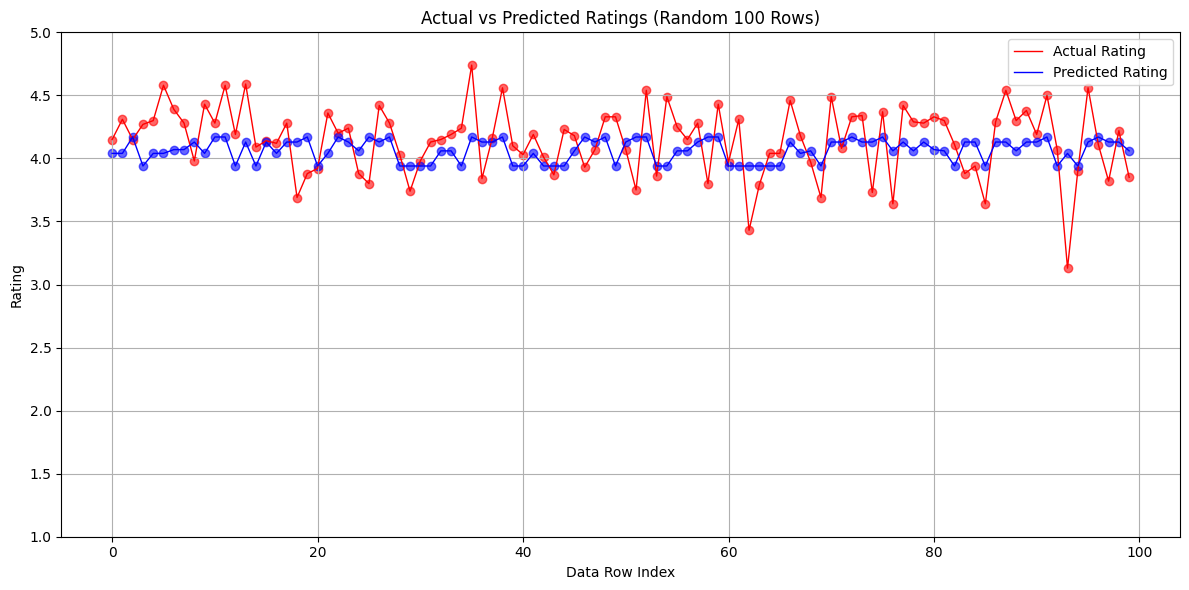

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = './archive/cleaned/merged_all_with_predictions_with_actualRating.csv'
df = pd.read_csv(file_path)

# Ensure ratings are numeric
df['actualRating'] = pd.to_numeric(df['actualRating'], errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Drop rows with missing ratings
df = df.dropna(subset=['actualRating', 'rating'])

# Keep only the first 1000 rows
df = df.head(100)

# X-axis: row index
x_values = range(len(df))

# Plot
plt.figure(figsize=(12, 6))

# Actual rating: red dots and red line
plt.plot(x_values, df['actualRating'], color='red', label='Actual Rating', linewidth=1)
plt.scatter(x_values, df['actualRating'], color='red', alpha=0.6)

# Predicted rating: blue dots and blue line
plt.plot(x_values, df['rating'], color='blue', label='Predicted Rating', linewidth=1)
plt.scatter(x_values, df['rating'], color='blue', alpha=0.6)

# Labels and settings
plt.xlabel('Data Row Index')
plt.ylabel('Rating')
plt.title('Actual vs Predicted Ratings (Random 100 Rows)')
plt.legend()
plt.grid(True)
plt.ylim(1, 5)  # Change this if your rating range differs

plt.tight_layout()
plt.show()


### Now we will do a dataset introduction

1. we will count books according to genre and make a graph about it
2. after prediction, repeat the no 1 again and compare how close the numbers are
3. count each genre on how many books they have and extract their author names and count them without duplicating then also plot them like no 1

In [29]:
import pandas as pd

# Load the genre comparison file
file_path = './archive/cleaned/genre_comparison.csv'
df = pd.read_csv(file_path)

# Combine both columns and get unique values
all_genres = df['predictedGenres']
unique_genres = all_genres.dropna().unique()

# Print the unique genres
print("📚 Unique Genre Options:")
for genre in sorted(unique_genres):
    print(genre)


📚 Unique Genre Options:
'
' algebra'
' baseball'
' cricket'
' football'
' hockey'
'adult'
'adventure'
'agriculture'
'amish literature'
'amish'
'amphigorey'
'animation'
'anthropology'
'architecture'
'art'
'astrology'
'astronomy'
'baking'
'biography'
'birds'
'black'
'book marketing'
'branding'
'brands'
'buddhism'
'building'
'business'
'card game'
'cats'
'chef'
'chess'
'chick lit'
'child development'
'childhood'
'childish'
'childrens'
'chinese literature'
'chinese'
'christian fiction'
'christian'
'christmas'
'cigarette smoking'
'classics'
'coding'
'coloring'
'comedic'
'comedy'
'comics'
'computers'
'cookbooks'
'corating'
'cosmology'
'crime'
'criminology'
'customer service'
'descent'
'design'
'diabetic'
'diary'
'directing'
'doctor who'
'doctor'
'dogs'
'dreams'
'dystopia'
'economics'
'education'
'entrepreneurship'
'epic'
'erotica'
'essays'
'fantasy'
'fashion'
'feminism'
'fiction'
'film'
'finance'
'finnish literature'
'food'
'forensics'
'france'
'friends'
'game design'
'games'
'geographie'
'g

### Now these are the most popular genres we found

fiction

fantasy

juvenile fiction

thriller

history

biography & autobiography

poetry

romance

philosophy

literary criticism

religion

horror

#### now we count

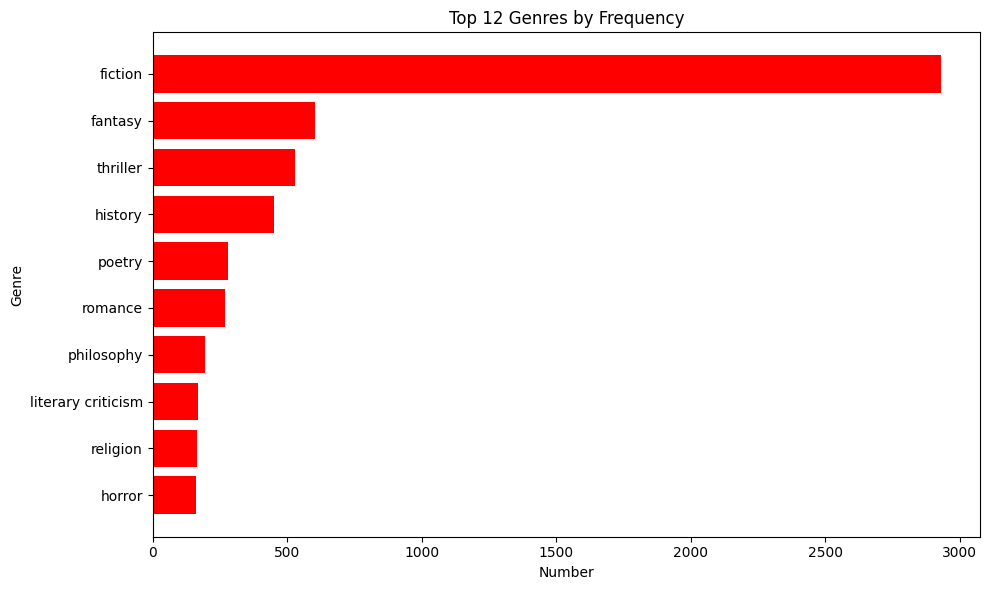

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the correct file
file_path = "./archive/cleaned/genre_comparison.csv"
df = pd.read_csv(file_path)

# Normalize the realGenres column
def normalize_genre(genre):
    if isinstance(genre, str):
        genre = genre.strip().lower()
        return genre.replace("['", "").replace("']", "").strip()
    return genre

df['normalized_genre'] = df['realGenres'].apply(normalize_genre)

# Define the 12 target genres to count
target_genres = [
    'fiction',
    'fantasy',
    'thriller',
    'history',
    'poetry',
    'romance',
    'philosophy',
    'literary criticism',
    'religion',
    'horror'
]

# Count occurrences of each genre
genre_counts = df['normalized_genre'].value_counts()
filtered_counts = {genre: genre_counts.get(genre, 0) for genre in target_genres}
sorted_counts = dict(sorted(filtered_counts.items(), key=lambda x: x[1], reverse=True))

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_counts.keys()), list(sorted_counts.values()), color='red')
plt.xlabel('Number')
plt.ylabel('Genre')
plt.title('Top 12 Genres by Frequency')
plt.gca().invert_yaxis()  # Highest count on top
plt.tight_layout()
plt.show()


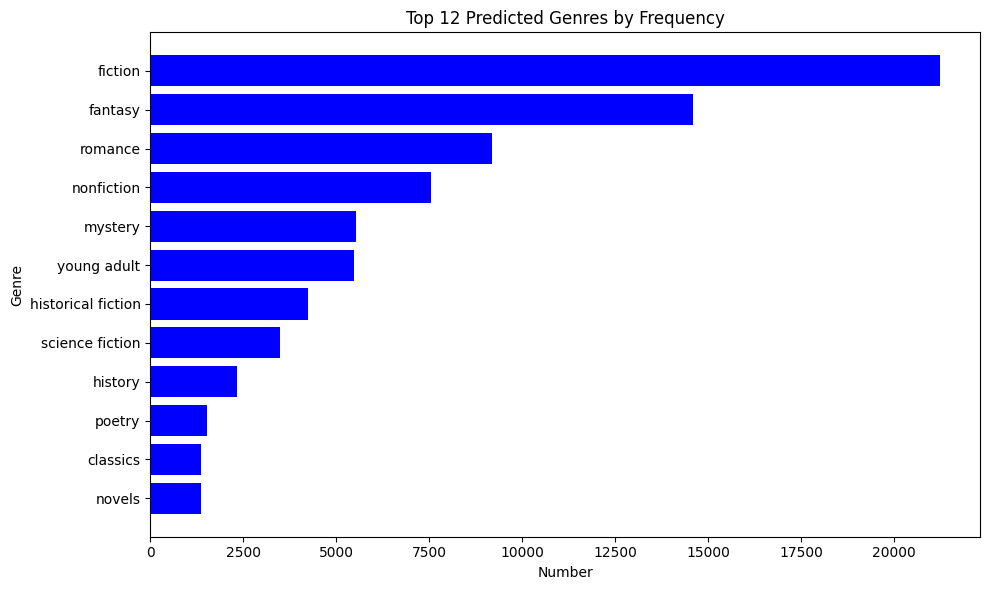

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
file_path = './archive/cleaned/Filtered_Top_12_Predicted_Genres.csv'
df = pd.read_csv(file_path)

# Clean predictedGenres
def clean_predicted_genre(genre):
    if isinstance(genre, str):
        genre = genre.lower().strip()
        genre = genre.replace("[", "").replace("]", "").replace("'", "").replace('"', '')
        return genre
    return genre

# Apply cleaning
df['clean_predicted_genre'] = df['predictedGenres'].apply(clean_predicted_genre)

# Remove empty genres
df = df[df['clean_predicted_genre'].notna() & (df['clean_predicted_genre'] != '')]

# Define top 12 predicted genres (you can also derive this from value_counts().head(12))
top_12_genres = [
    'fiction',
    'fantasy',
    'romance',
    'nonfiction',
    'mystery',
    'young adult',
    'historical fiction',
    'science fiction',
    'history',
    'poetry',
    'classics',
    'novels'
]

# Filter only those rows that are in top 12
filtered_df = df[df['clean_predicted_genre'].isin(top_12_genres)]

# Count and sort genre frequency
genre_counts = filtered_df['clean_predicted_genre'].value_counts().sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(genre_counts.index, genre_counts.values, color='blue')
plt.xlabel('Number')
plt.ylabel('Genre')
plt.title('Top 12 Predicted Genres by Frequency')
plt.tight_layout()
plt.show()


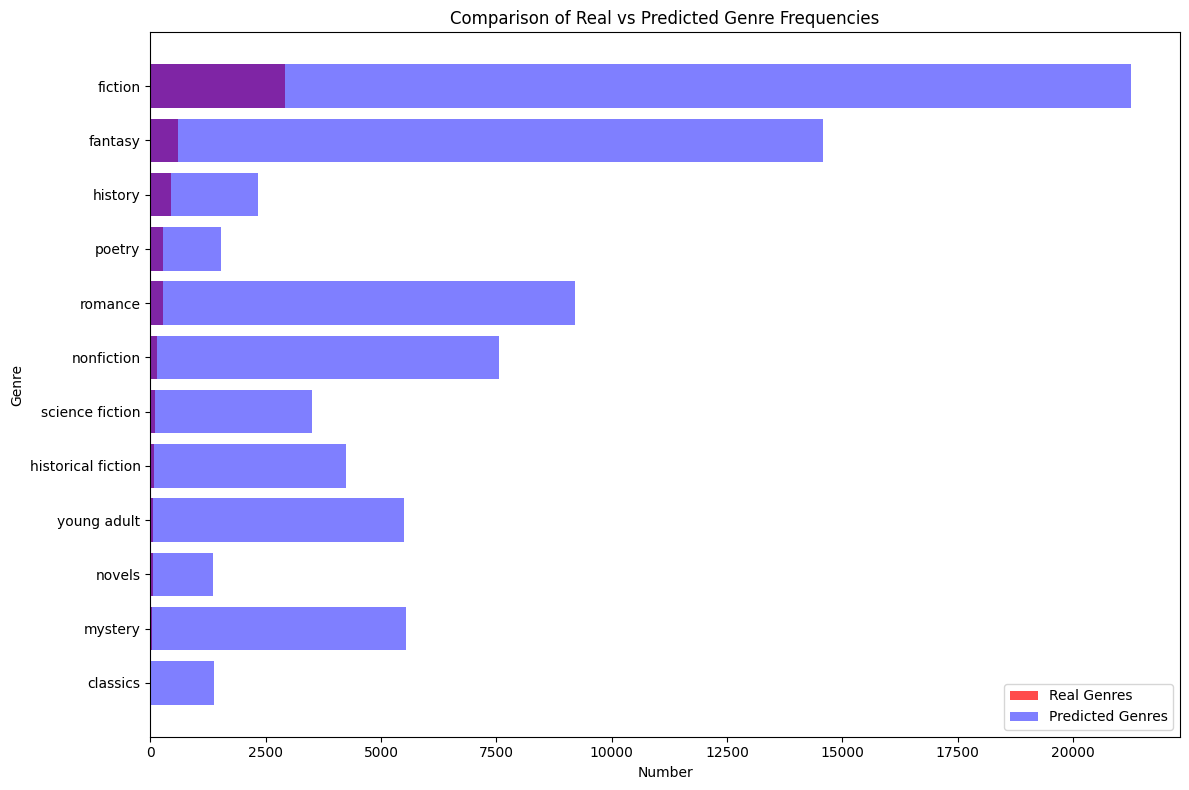

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load files
real_df = pd.read_csv("./archive/cleaned/genre_comparison copy.csv")
predicted_df = pd.read_csv("./archive/cleaned/Filtered_Top_12_Predicted_Genres.csv")

# Clean real genres
def clean_genre(genre):
    if isinstance(genre, str):
        genre = genre.strip().lower()
        genre = genre.replace("[", "").replace("]", "").replace("'", "").replace('"', '')
        return genre
    return genre

real_df['clean_real_genre'] = real_df['realGenres'].apply(clean_genre)
predicted_df['clean_predicted_genre'] = predicted_df['clean_predicted_genre'].apply(clean_genre)

# Count real and predicted genres
real_counts = real_df['clean_real_genre'].value_counts()
predicted_counts = predicted_df['clean_predicted_genre'].value_counts()

# Combine into one DataFrame
all_genres = sorted(set(real_counts.index).union(set(predicted_counts.index)))
comparison_df = pd.DataFrame({
    'Real': [real_counts.get(g, 0) for g in all_genres],
    'Predicted': [predicted_counts.get(g, 0) for g in all_genres]
}, index=all_genres)

# Filter only genres present in both sets
comparison_df = comparison_df.loc[(comparison_df['Real'] > 0) & (comparison_df['Predicted'] > 0)]

# Sort by real genre frequency
comparison_df = comparison_df.sort_values(by='Real', ascending=True)

# Plot
plt.figure(figsize=(12, 8))
plt.barh(comparison_df.index, comparison_df['Real'], label='Real Genres', color='red', alpha=0.7)
plt.barh(comparison_df.index, comparison_df['Predicted'], label='Predicted Genres', color='blue', alpha=0.5)
plt.xlabel('Number')
plt.ylabel('Genre')
plt.title('Comparison of Real vs Predicted Genre Frequencies')
plt.legend()
plt.tight_layout()
plt.show()


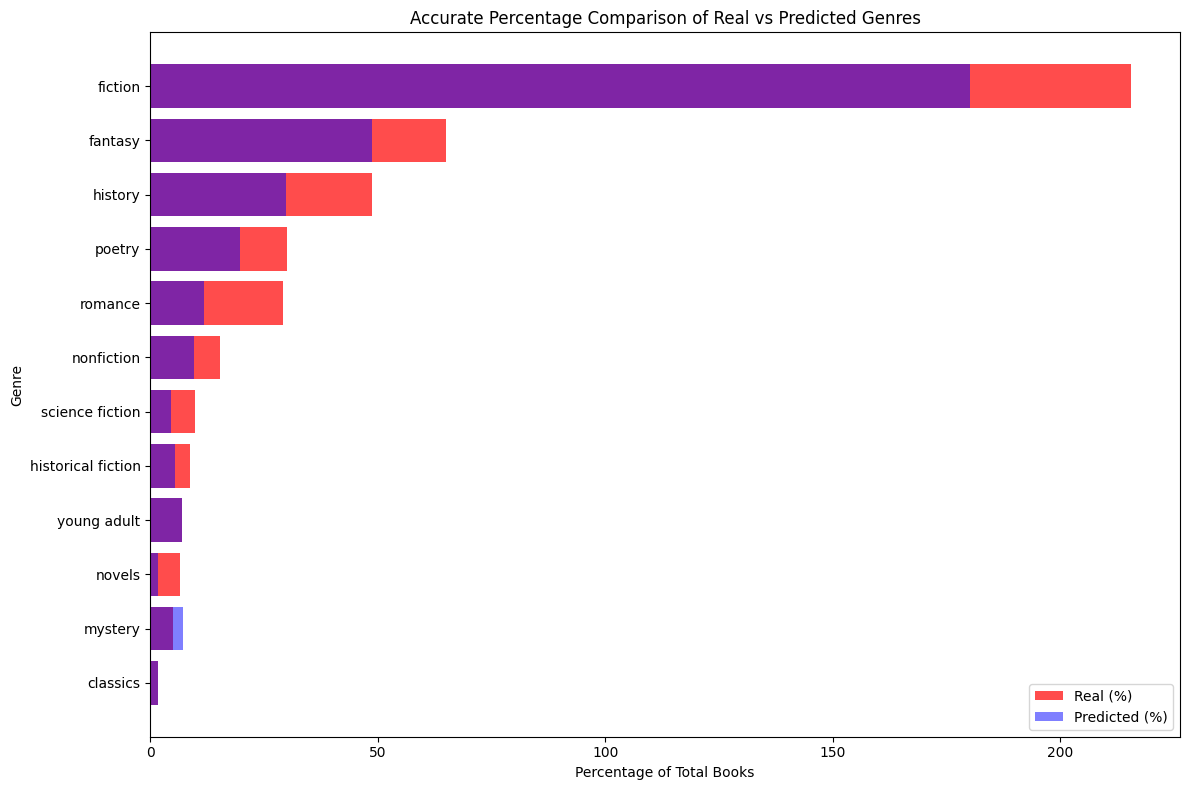

In [2]:
import pandas as pd
import matplotlib.pyplot as plt



# Load the uploaded percentage comparison CSV
df_percent = pd.read_csv("./archive/cleaned/accurate_genre_percentage_comparison.csv", index_col=0)

# Sort by real genre percentage for better visual order
df_percent = df_percent.sort_values(by='Real (%)', ascending=True)

# Plot
plt.figure(figsize=(12, 8))
plt.barh(df_percent.index, df_percent['Real (%)'], label='Real (%)', color='red', alpha=0.7)
plt.barh(df_percent.index, df_percent['Predicted (%)'], label='Predicted (%)', color='blue', alpha=0.5)
plt.xlabel('Percentage of Total Books')
plt.ylabel('Genre')
plt.title('Accurate Percentage Comparison of Real vs Predicted Genres')
plt.legend()
plt.tight_layout()
plt.show()

